## Ex2

•	Passer d'un couple image + fichier vecteur bâtiment à une image masque de bâtiment avec les pixels bâtiment ayant une valeur 1 et les autres 0.

Etapes : 

-	Pour la lecture du fichier vecteur. regarder soit la librairie fiona (https://fiona.readthedocs.io/en/latest/manual.html) lecture fichier en mode stream et sous forme de json (avec information geo) ou geopandas (https://geopandas.org/) qui lit en fichier sous forme de dataframe pandas avec une colonne geometry. Geopandas peut être plus simple si tu connais déjà la librairies python pandas.

-	Pour la rasterization il faut regarder du côté de la méthode rasterio.features.rasterize de la librairie rasterio


In [2]:
import os
import os.path
from pathlib import Path
import numpy as np 

import geopandas as gpd
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt

First define global/config parameters

In [4]:
root_data_dir = "/media/DATA/DATASETS_AI/OCSGE_URBAN/33_2018"  # TODO change to your own data dir
os.listdir(os.path.join(root_data_dir,"IMAGES","A1_RVB"))

['.DS_Store',
 'readme.txt',
 'rvb.vrt',
 'zone_1.tif',
 'zone_2.tif',
 'zone_3.tif',
 'zone_4.tif',
 'zone_5.tif']

### data structure
Data_dir contains two subdirectory :
 * "IMAGES" with images data 
 * "MASKS" other with mask (ground truth/label) data. 

Theres is 5 regions of interset in IMAGES dir, call zone_1 to zone_5. 
Each zone has mutiples images in dedicated subdir. Images of the same zone have the same name but different path/subdir :
 * RVB images are in "A1_RVB" subdir
 * IRC images are in "A2_IRC" subdir

In [5]:
img_path = os.path.join(root_data_dir,"IMAGES","A1_RVB", "zone_1.tif")
buildings_labels_path = os.path.join(root_data_dir,"MASKS","mask_bati_33_2018.shp")

out_raster = os.path.join(root_data_dir, "OUTPUT", "new_1.tif")
# make output directory if not existing
Path(os.path.join(root_data_dir, "OUTPUT")).mkdir(parents=True, exist_ok=True)

### Read files & get geometry features

In [6]:
# read shapefile with geopandas 
buildings = gpd.read_file(buildings_labels_path)

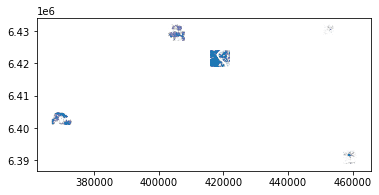

In [7]:
buildings.plot()
plt.show()

we see that the shapefile contains labels for all of the five region of interest

### Read image & get metadata
First we read the metadata of the image that must serve as template for the rasterization. It defined the zone (coordinate) and resolution of the rasterization. 

In [8]:
# open raster file 
template_rds = rasterio.open(img_path) # rds raster dataset

as we are only interested in metadata we copy them and close the input image.

In [9]:
# copy metadata 
meta = template_rds.meta.copy()
template_rds.close()

In [10]:
print(meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 30000, 'height': 20000, 'count': 3, 'crs': CRS.from_epsg(2154), 'transform': Affine(0.2, 0.0, 367000.0,
       0.0, -0.2, 6405000.0)}


### Initialize output  image 
the output image must :
  * have the same spatial dimension and resolution than the input image
  * have only 1 channel and not three (rvb image). 

So we initialized output_image with the metadata of input image with update channel/count number 

In [11]:
# update the number of band to 1 for output image 
meta.update(count=1)

In [12]:
# Initialize a new tif file 
out_rds = rasterio.open(out_raster,'w+',**meta) 

### Create numpy array with rasterio

In [13]:
# initialize output numpy array when reading output image to have the good numpy array shape.
out_arr = out_rds.read(1)
print(out_arr.shape)

(20000, 30000)


for rasterization we have to define a rasterization value for all geometries and a default value for pixel outside of building geometries.

* the geometrie and "burning value" are passed as a list of tuple (geometrie, burn_value)
* the default value is the fill argument of the rasterio.feature.rasterize function

In [14]:
# get the shape 
shapes = [(geom, 1) for geom in buildings.geometry]
# Create a mask 
burned = rasterize(shapes=shapes, fill=0, out=out_arr, transform=out_rds.transform)

##### Some test to check / debug the rasterization.

first check if some values have "1" as value.

In [15]:
print(f"burned max value : {burned.max()}")
print(f"burned sum/nb building pixel : {burned.sum()}")
building_ratio = burned.sum()*1.0/(out_arr.shape[0]*out_arr.shape[1])
print(f"building ratio : {building_ratio*100:.1f}%")
print(burned.dtype)

burned max value : 1
burned sum/nb building pixel : 51733372
building ratio : 8.6%
uint8


if something wrong, check the coordinate system of building and image, get image bounding box and filter/count the number of building inside this bounding box.

In [16]:
img_envelop = out_rds.bounds
print(img_envelop)
xmin, ymin, xmax, ymax = list(img_envelop)
img_buildings = buildings.cx[xmin:xmax, ymin:ymax]
print(f"builing inside image: {img_buildings.size}")

BoundingBox(left=367000.0, bottom=6401000.0, right=373000.0, top=6405000.0)
builing inside image: 65589


### Save result
* write burned array to output dataset
* write file by closing raster dataset (alternative using "with")

In [17]:
# Write the mask 
out_rds.write_band(1, burned)
out_rds.close()

check result by reading and display output image

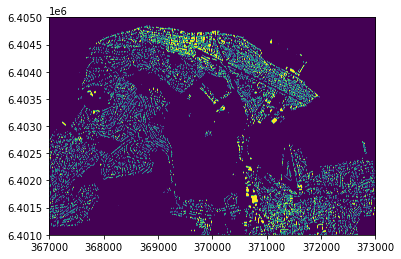

In [18]:
with rasterio.open(out_raster,'r',**meta) as out_ds :
   rasterio.plot.show(out_ds)

## Other Method

In [ ]:
src_rvb = rasterio.open("./IMAGES/A1_RVB/zone_1.tif")

### Reading dataset masks

In [ ]:
src_rvb.read_masks(1)

In [ ]:
metadata = src_rvb.meta

In [ ]:
raster_img = src_rvb.read()

In [ ]:
metadata

In [ ]:
# reshaping rasters
raster_img = reshape_as_image(raster_img)

### Visualize Image

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

### Loading ShapeFile with Geopandas 

In [ ]:
gdf = gpd.read_file('./MASKS/mask_bati_33_2018.shp')

In [ ]:
gdf.head()

In [ ]:
print("CRS Raster: {}, CRS Vector {}".format(gdf.crs, src_rvb.crs))

### Mask with Rasterio

In [ ]:
gdf.crs = {'init':'epsg:2154'}
gdf = gdf.to_crs({'init':metadata['crs']['init']})

In [ ]:
# Generate a polygon
gdf.geometry

In [ ]:
# cascased union : return a representation of union geometric objects 
cascaded_union(gdf.geometry[0])

In [ ]:
gdf.columns

In [ ]:
gdf.shape

In [ ]:
gdf.geometry

In [ ]:
# Checking Coordinates 
gdf.geometry[0].exterior.coords.xy

In [ ]:
# Cut fields from raster 
failed = []
for num, row in gdf.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src_rvb, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

In [ ]:
metadata['crs']

In [ ]:
## Converting GeoDataframe to raster CRS 
# let's remove rows without geometry
gdf = gdf[gdf.geometry.notnull()]

# assigning crs
gdf.crs = {'init' :'epsg:2154'}

#transforming polygons to the raster crs
gdf = gdf.to_crs({'init' : metadata['crs']['init']})

In [ ]:
outfolder = "article"
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in gdf.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src_rvb, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['FID']) + '.png')
        #img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        #cv2.imwrite(img_path, img_image)
    except Exception as e:
#         print(e)
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

In [ ]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly


In [ ]:
src_rvb.meta['transform'][:]

In [ ]:
gdf.geometry[0].exterior.coords[0]

In [ ]:
# creating binary mask for field/not_filed segmentation.
"""
poly_shp = []
im_size = (src_rvb.meta['height'], src_rvb.meta['width'])
for num, row in gdf.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        print(row['geometry'])
        poly = poly_from_utm(row['geometry'], src_rvb.meta['transform'][:])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src_rvb.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask
plt.figure(figsize=(15,15))
plt.imshow(mask)
"""

Geometry Objects Attributes:

- area

- bounds

- length

- minimum_clearance

- geom_type

- distance


In [ ]:
gdf.geometry[0].geom_type

In [ ]:
type(gdf.geometry[0])

In [ ]:
# area 
gdf.geometry[0].area

In [ ]:
# bounds : minx, miny, maxx, maxy
gdf.geometry[0].bounds